To investigate the effect of wall thickness, we adapt the previous infinite periodic wall program. Instead of defining a single column of grid points as an insulator, we now create a solid, centered block of insulator points with the specified thickness. We shall also use the solution for a thinner wall as a starting condition for a solution for a thicker wall.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def create_thick_wall_mask(Nx, Ny, hole_size_grid, wall_thickness_grid):
    '''
    Creates a boolean mask for a single period of the wall with variable thickness.
    '''
    is_insulator = np.full((Ny, Nx + 1), False)

    # Define the start and end columns for the centered wall
    center_j = Nx // 2
    start_j = center_j - wall_thickness_grid // 2
    end_j = start_j + wall_thickness_grid

    # Ensure indices are valid
    start_j = max(1, start_j) # Keep away from fixed boundaries
    end_j = min(Nx, end_j)

    # Create the solid wall block
    is_insulator[:, start_j:end_j] = True

    # Punch the central hole through the block
    center_i = Ny // 2
    start_hole_i = center_i - hole_size_grid // 2
    end_hole_i = start_hole_i + hole_size_grid

    is_insulator[start_hole_i:end_hole_i, start_j:end_j] = False

    return is_insulator


def solve_laplace_thick_wall(Nx, Ny, hole_size_grid, wall_thickness_grid,
                             initial_T=None, sigma=1.9, tol=1e-7, max_iter=30000):
    '''
    Solves Laplace's equation for a periodic wall with variable thickness.
    Accepts an initial temperature grid to accelerate convergence.
    '''
    # Initialisation
    if initial_T is not None:
        T = initial_T.copy()
        print(f"Solving for thickness={wall_thickness_grid} using previous solution")
    else:
        T = np.full((Ny, Nx + 1), 0.5)
        print(f"Solving for thickness={wall_thickness_grid} from scratch")

    is_insulator = create_thick_wall_mask(Nx, Ny, hole_size_grid, wall_thickness_grid)

    # Apply Fixed Boundary Conditions (Left/Right)
    T[:, 0] = 0.0
    T[:, Nx] = 1.0

    # Iteration Loop
    for iteration in range(max_iter):
        T_old = T.copy()

        for i in range(Ny):
            for j in range(1, Nx):
                if is_insulator[i, j]: continue

                up_i = (i + 1) % Ny
                down_i = (i - 1 + Ny) % Ny

                term_U = T[up_i, j]
                term_D = T[down_i, j]
                term_R = T[i, j - 1] if is_insulator[i, j + 1] else T[i, j + 1]
                term_L = T[i, j + 1] if is_insulator[i, j - 1] else T[i, j - 1]

                T[i, j] = (1 - sigma) * T_old[i, j] + \
                          (sigma / 4.0) * (term_U + term_D + term_R + term_L)

        max_change = np.abs(T - T_old).max()
        if max_change < tol:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break
    else:
        print(f"Max iterations ({max_iter}) reached.")

    return T, is_insulator

Solving for thickness=2 from scratch
Convergence reached after 833 iterations.
Solving for thickness=5 using previous solution
Convergence reached after 561 iterations.
Solving for thickness=10 using previous solution
Convergence reached after 512 iterations.
Solving for thickness=20 using previous solution
Convergence reached after 447 iterations.
Solving for thickness=40 using previous solution
Convergence reached after 274 iterations.


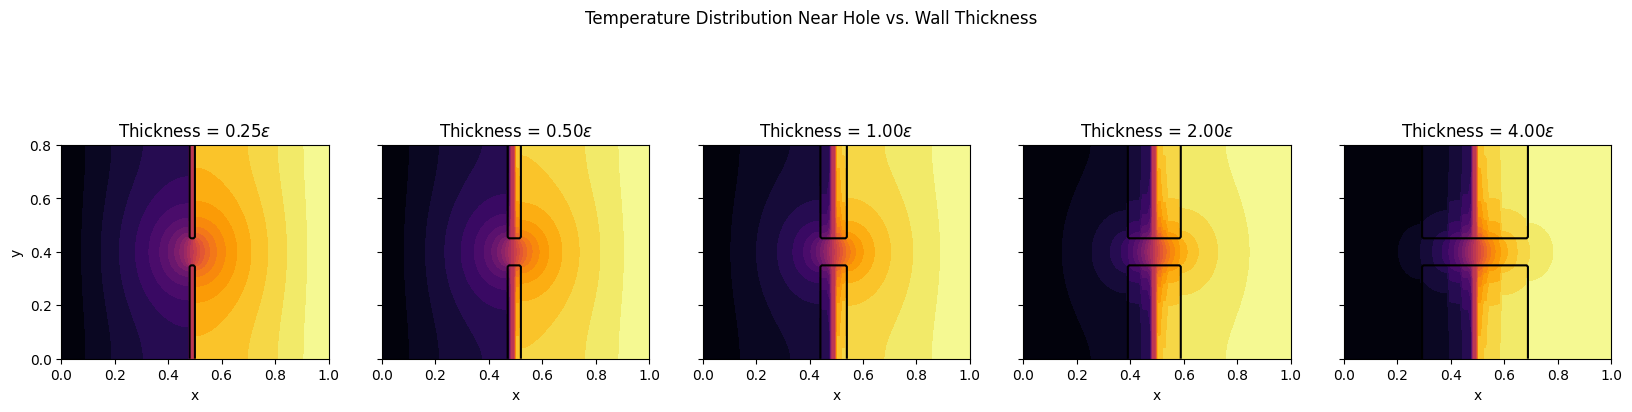

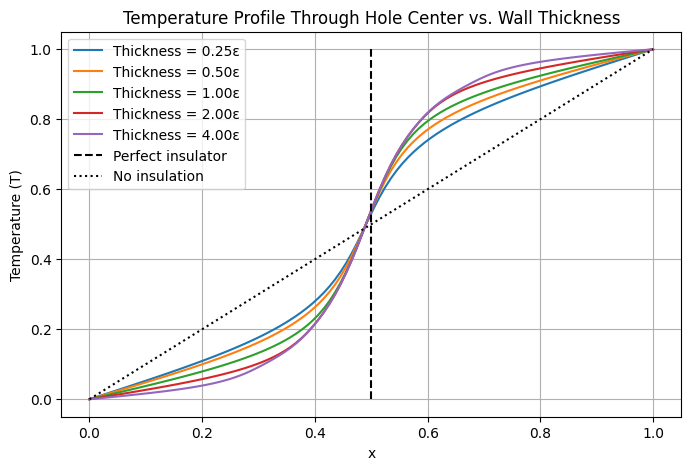

In [15]:
NX_VAL = 101
EPSILON_REAL = 0.1
DELTA_REAL = 8 * EPSILON_REAL
HOLE_GRID = int(EPSILON_REAL * NX_VAL)
NY_GRID = int(DELTA_REAL * NX_VAL)
thickness_multipliers = [0.25, 0.5, 1.0, 2.0, 4.0]
thicknesses_real = [m * EPSILON_REAL for m in thickness_multipliers]

T_solution = None  # To hold the solution from the previous step
results = {}       # Dictionary to store results for plotting
walls = {}          # Dictionary to hold the walls

for i, thick_real in enumerate(thicknesses_real):
    thick_grid = int(thick_real * NX_VAL)

    T_solution, wall_mask = solve_laplace_thick_wall(
        Nx=NX_VAL, Ny=NY_GRID,
        hole_size_grid=HOLE_GRID,
        wall_thickness_grid=thick_grid,
        initial_T=T_solution # Use previous solution as initial guess
    )
    results[thick_real] = T_solution.copy()
    walls[thick_real] = wall_mask.copy()

# Contour Plots
fig, axes = plt.subplots(1, len(thicknesses_real), figsize=(20, 5), sharey=True)
fig.suptitle('Temperature Distribution Near Hole vs. Wall Thickness')

for i, (thick_real, T) in enumerate(results.items()):
    ax = axes[i]
    x = np.linspace(0, 1, NX_VAL + 1)
    y = np.linspace(0, DELTA_REAL, NY_GRID)
    X, Y = np.meshgrid(x, y)

    ax.contourf(X, Y, T, levels=30, cmap='inferno')
    # Draw the wall at the centre of the grid with desired thickness and gap
    ax.contour(X, Y, walls[thick_real], levels=[0.5], colors='black')
    ax.set_title(f'Thickness = {thickness_multipliers[i]:.2f}$\\epsilon$')
    ax.set_xlabel('x')
    if i == 0: ax.set_ylabel('y')

    #ax.set_xlim(0.5 - 2*EPSILON_REAL, 0.5 + 2*EPSILON_REAL)
    #ax.set_ylim(DELTA_REAL/2 - 2*EPSILON_REAL, DELTA_REAL/2 + 2*EPSILON_REAL)
    ax.set_aspect('equal')

plt.show()

plt.figure(figsize=(8, 5))
x_vals = np.linspace(0, 1, NX_VAL + 1)
hole_center_idx = NY_GRID // 2

for thick_real, T in results.items():
    cross_section = T[hole_center_idx, :]
    label_text = f"Thickness = {thick_real/EPSILON_REAL:.2f}ε"
    plt.plot(x_vals, cross_section, label=label_text)

# Plot vertical asymptote at x=0.5 and diagonal from (0, 0) to (1, 1) for comparison
plt.plot([0.5, 0.5], [0, 1], 'k--', label='Perfect insulator')
plt.plot([0, 1], [0, 1], 'k:', label='No insulation')

plt.title('Temperature Profile Through Hole Center vs. Wall Thickness')
plt.xlabel('x')
plt.ylabel('Temperature (T)')
plt.grid(True)
plt.legend()
plt.show()

As the wall gets thicker, the region of intermediate temperature inside the hole expands. The contour lines, which represent lines of constant temperature, are pulled into the hole. For the thinnest wall, the temperature changes abruptly from cold to hot across the hole's opening. For the thickest wall, this transition is much more gradual and occurs over the entire length of the hole.

The hole acts like a channel connecting the cold region to the hot region. The thickness of the wall determines the length of this channel. A thinner wall has less insulation, so the difference between the cold and hot regions is smaller compared to a thicker wall. This can be seen by observing the order of the temperature lines in the cross section through the hole. The thickness of the wall determines how much heat flux is able to pass through unimpeded.

A perfect insulator would have a vertical asymptote at the wall whereas a perfect conductor would be a straight line with constant gradient.



---

In reality, there is a consideration to be made where we aim to balance the need for thermal insulation with liquid or gaseous permeability. Based upon our results:
*   Prioritise numerous small holes over fewer large holes. The case where the hole size shrank faster than the spacing resulted in better insulation properties. In particular, keep the openness ratio $\epsilon/\delta$ low.

*   For a given hole size and spacing, increasing the wall thickness substantially improves its insulating quality. This creates a longer thermal channel that heat must pass through.

*   Adding the very first holes to a solid insulating sheet has a disproportionately large negative impact on its performance. We should determine the minimum acceptable level of permeability, as any additional openness will reduce the insulating quality with diminishing returns for breathability.


Physical assumptions:
*   Conduction only: The model completely ignores two dominant modes of heat transfer which are convection (air flow or wind) and radiation (particularly with high temperature differences).
*   Steady-state solution: The model only calculates the final, equilibrium temperature distribution. It provides no information about transient effects such as the time it takes to heat up or cool down.
*   Perfect insulator naterial: The wall material itself is assumed to have perfectly zero thermal conductivity.
*   Idealised boundary conditions: The $T=0$ and $T=1$ boundaries are perfect heat sources and sinks. In reality, the air temperature on either side would be affected by the rate of heat flow through the sheet.

Geometric simplifications:
*   Two-dimensional nodel: The simulation is a 2D slice. A real sheet is 3D, and the fluid dynamics of gas passing through a 3D hole are more complex.
*   Perfect geometry: The model assumes a perfectly repeating, grid-aligned pattern of circular (approximated as square) holes. Real-world materials may have irregular distributions.
*   Infinite and finite idealisations: Both the infinite periodic model and the finite box with perfectly insulated top and bottom are idealisations which ignore edge effects due to edges and corners.

The model could be extended in several ways, each adding a layer of complexity and computational cost.
*   Convection is a significant affect, so the most critical step towards realism would be to couple the heat equation with the Navier-Stokes equations in fluid dynamics to simulate air flow.
*   The grid should also be extended to three dimensions where the relaxation formula would averge six neighbours instead of four.
*   We should solve the full time-dependent heat equation instead of the equilibrium Laplace equation. This involves a time-stepping algorithm which allows us to understand the response time of an insulating wall.
*   Replacing the current finite difference grid with a more flexible mesh would allow the modelling of non-uniform geometries.
*   Using convective boundary conditions, which model the heat transfer to a fluid rather than assuming the surface is fixed at that temperature would provide insight into how the insulating sheet interacts with the environment.